# 3D spectral analysis of HESS J1745-290 (with HAP-fr)

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [29]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [30]:
from pathlib import Path

# General path (to select which analysis/set of data we work with)
path = Path("../../../hess_results/GC_variability_0.18.2/hap-fr")
path.mkdir(exist_ok=True)

pathma = Path(path/"mapdatasets")
pathma.mkdir(exist_ok=True)

# To find the model template
pathm = Path(path/"models")
pathm.mkdir(exist_ok=True)

model_name = pathm/"models_template_2cutoff.yaml"

# Directory for outputs
path3d = Path(path/"3Dspectra")
path3d.mkdir(exist_ok=True)

In [31]:
pathtry = Path(path3d/"2amps_2indexes_2cutoff/HESS2_specific")
pathtry.mkdir(exist_ok=True)

pathFP = Path(pathtry/"fluxpoints")
pathFP.mkdir(exist_ok=True)

In [32]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

## Creating the geometry

In [33]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

## The mask

In [34]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 3*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.75 * u.deg)

mask_fit = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

mask_fit = Map.from_geom(geom, data=mask_fit)

## Useful functions

In [35]:
def fit_dataset(dataset, models):

    dataset.mask_fit = fit_mask
    dataset.models =  models
    bkg_model = FoVBackgroundModel(dataset_name = dataset.name)

    fit = Fit([dataset])
    result = fit.run()
    
    table = result.parameters.to_table()

    models_fitted = dataset.models.copy()
    
    return table, result, models_fitted


def fit_joint_datasets(datasets, models):

    for dataset in datasets:
        dataset.mask_fit = fit_mask
        dataset.models =  models
        bkg_model = FoVBackgroundModel(dataset_name = dataset.name)

    fit = Fit(datasets)
    result = fit.run()
    
    table = result.parameters.to_table()

    models_fitted = datasets[0].models.copy()
    
    return table, result, models_fitted

In [36]:
def plot_spectrum(models, path ,namefile, name):
    plt.figure(figsize=(12,8))
    plot_kwargs = {
        "energy_range": [0.1, 30] * u.TeV,
        "energy_power": 2,
        "flux_unit": "erg-1 cm-2 s-1",
    }

    ## central source
    index = models[0].spectral_model.parameters["index"].value
    amp = models[0].spectral_model.parameters["amplitude"].value
    
    if models[0].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[0].spectral_model.parameters["lambda_"].value
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff))
    else :  
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[0].spectral_model.plot_error(**plot_kwargs)

    
    ## diffuse model
    index = models[2].spectral_model.parameters["index"].value
    amp = models[2].spectral_model.parameters["amplitude"].value
    
    if models[2].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[2].spectral_model.parameters["lambda_"].value
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse   : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff ))
    else :  
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse   : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[2].spectral_model.plot_error(**plot_kwargs)

    plt.title("Spectral models fitted for a constant GC source (" + name + ")")
    plt.legend()
    plt.savefig(path/namefile)

In [37]:
def FluxPointsFitting(datasets, num, e_edges, namefile):
    # this function has to be given the number of the source model in case of multiple models
    # more parameters exist to initialise the estimator
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source =num) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset.models[num])
    plt.figure(figsize=(8, 6))
    flux_points_dataset.plot_fit()
    name = "fluxpoints_"+namefile+".pdf"
    plt.savefig(pathFP/name)
    

In [54]:
def DoubleFluxPointsFitting(datasets, e_edges, namefile, name):
    # plots source flux points and DE flux points at once, without the residuals thingy
    
    plt.figure(figsize=(12,8))
    #plot_kwargs = {
    #    "energy_range": [0.1, 30] * u.TeV,
    #    "energy_power": 2,
    #    "flux_unit": "erg-1 cm-2 s-1",
    #}
    
    ## central source
    fpe = FluxPointsEstimator( energy_edges=e_edges, source = 0) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset_GC = FluxPointsDataset(data=flux_points, models=datasets.models[0])
    
    index = datasets.models[0].spectral_model.parameters["index"].value
    amp = datasets.models[0].spectral_model.parameters["amplitude"].value
    
    if datasets.models[0].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/datasets.models[0].spectral_model.parameters['lambda_'].value
        label_modelGC = {"label" : f"HESS J1745-290 : index = {index:03.3f} , amplitude = {10**12*amp:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {cutoff:03.3f} TeV"}
    else :  
        label_modelGC = {"label" : r"HESS J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp )}

    
    ## diffuse model
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source = 2) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset_DE = FluxPointsDataset(data=flux_points, models=datasets.models[2])

    index = datasets.models[2].spectral_model.parameters["index"].value
    amp = datasets.models[2].spectral_model.parameters["amplitude"].value
    
    if datasets.models[2].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/datasets.models[2].spectral_model.parameters["lambda_"].value
        label_modelDE = {"label" : f"diffuse     : index = {index:03.3f} , amplitude = {10**12*amp:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {cutoff:03.3f} TeV"}
    else :  
        label_modelDE = {"label" : r"diffuse     : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp )}

    flux_points_dataset_GC.plot_spectrum( kwargs_fp = {"label":"HESS J1745-290 flux points"}, kwargs_model = label_modelGC)
    flux_points_dataset_DE.plot_spectrum( kwargs_fp = {"label":"Diffuse emission flux points"}, kwargs_model = label_modelDE)
    
    plt.title("Spectral models and flux points (" + name + ")")
    plt.legend()
    name = "fluxpoints_"+namefile+".pdf"
    plt.savefig(pathFP/name)

In [39]:

def residuals(dataset, namefile, namefig):
    region = CircleSkyRegion(center=src_pos, radius=0.5 * u.deg)

    kwargs_spatial = {'vmin':-1, 'vmax':1 } # nécessaire ?

    kwargs_spectral = {'method':'diff/sqrt(model)', 'region' : CircleSkyRegion(center=src_pos, radius=0.3 * u.deg)}

    dataset.plot_residuals(kwargs_spatial=kwargs_spatial, kwargs_spectral=kwargs_spectral)
    #plt.plot((0,0), '*')
    plt.title("residuals (diff/sqrt(model)) " + namefig)
    name = "residuals_" + namefile +"_fr.pdf"
    plt.savefig(pathtry/name, overwrite=True)

In [40]:
from scipy.stats import norm


def significance(dataset, namefile, namefig):
    #plt.figure(figsize=(6,6))

    lima_estimator = ExcessMapEstimator("0.2 deg", selection_optional=[] )
    
    res =  lima_estimator.run(dataset)
    
    res['sqrt_ts'].plot(add_cbar=True)
    #plt.plot((0,0), '*')
    
    namepdf = "significance_"+namefile+"_fr.pdf"
    namefits = "significance_"+namefile+"_fr.fits"
    
    plt.title("Significance map (data v. predictions) "+namefig)
    
    plt.savefig(pathtry/namepdf, overwrite=True)
    res['sqrt_ts'].write(pathtry/namefits, overwrite=True)
    
    
    plt.figure()
    signidata = res['sqrt_ts'].cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    # on masque la région en bas à droite
    mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    signidata_masked = signidata[0,mask]
    
    plt.hist(signidata_masked.flatten(),30, histtype='step', density=True)
    
    # what about cutting values above 5/below -5 ?
    x = np.abs(signidata_masked) < 5
    mean,std=norm.fit(signidata_masked[x])
    
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    y2= norm.pdf(x, 0, 1)   
    plt.plot(x, y2 ,label=r'$\mu$ = 0, $\sigma$ = 1')
    
    plt.legend()
    
    name = "significance_hist_"+namefile+"_fr.pdf"
    plt.title("Significance distribution on the central (3°,1.5°) "+namefig)
    plt.savefig(pathtry/name, overwrite=True)

# The Data

In [41]:
dataset2_zenhigh_tot = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
filename = "HESS2/mapdataset_hess2_30-50angzen.fits.gz"
dataset2_zenhigh_tot = MapDataset.read(pathma/filename)

dataset2_zenlow_tot = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
filename = "HESS2/mapdataset_hess2_0-30angzen.fits.gz"
dataset2_zenlow_tot = MapDataset.read(pathma/filename)

In [44]:
dataset2_zenhigh = dict()

dataset2_zenhigh[2013] = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
filename = "HESS2/mapdataset_hess2_2013_30-50angzen.fits.gz"
dataset2_zenhigh[2013] = MapDataset.read(pathma/filename)

dataset2_zenhigh[2014] = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
filename = "HESS2/mapdataset_hess2_2014_30-50angzen.fits.gz"
dataset2_zenhigh[2014] = MapDataset.read(pathma/filename)

dataset2_zenhigh[2015]= MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
filename = "HESS2/mapdataset_hess2_2015_30-50angzen.fits.gz"
dataset2_zenhigh[2015] = MapDataset.read(pathma/filename)

dataset2_zenhigh[2016] = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
filename = "HESS2/mapdataset_hess2_2016_30-50angzen.fits.gz"
dataset2_zenhigh[2016] = MapDataset.read(pathma/filename)

In [43]:
dataset2_zenlow = dict()

dataset2_zenlow[2013] = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
filename = "HESS2/mapdataset_hess2_2013_0-30angzen.fits.gz"
dataset2_zenlow[2013] = MapDataset.read(pathma/filename)

dataset2_zenlow[2014] = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
filename = "HESS2/mapdataset_hess2_2014_0-30angzen.fits.gz"
dataset2_zenlow[2014] = MapDataset.read(pathma/filename)

dataset2_zenlow[2015] = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
filename = "HESS2/mapdataset_hess2_2015_0-30angzen.fits.gz"
dataset2_zenlow[2015] = MapDataset.read(pathma/filename)

dataset2_zenlow[2016] = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)
filename = "HESS2/mapdataset_hess2_2016_0-30angzen.fits.gz"
dataset2_zenlow[2016] = MapDataset.read(pathma/filename)

## Reading the model template

In [45]:
modelGC,modelG09, model_diff = Models.read(model_name)

## Setting which parameters will vary

In [46]:
modelGC.parameters["index"].frozen = False
modelGC.parameters["index"].value = 1.83

modelGC.parameters["lon_0"].frozen = True
modelGC.parameters["lat_0"].frozen = True
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["reference"].frozen = True 

modelG09.parameters["index"].frozen = True
modelG09.parameters["lat_0"].frozen = True
modelG09.parameters["amplitude"].frozen = False

model_diff.parameters["index"].frozen = False
model_diff.parameters["index"].value = 2.3

#model_diff.parameters["norm"].frozen = True
model_diff.parameters["amplitude"].frozen = False
model_diff.parameters["reference"].frozen = True

In [47]:
# if there are cutoffs in the spectra

modelGC.parameters["lambda_"].frozen = False
modelGC.parameters["lambda_"].value = 1/8.77

model_diff.parameters["lambda_"].frozen = False
model_diff.parameters["lambda_"].value = 1/20.0

# Fitting the many datasets

In [48]:
%%time

models = modelGC.copy() + modelG09.copy()+ model_diff.copy()

table, result, models_zenhigh = fit_dataset(dataset2_zenhigh_tot, models)

CPU times: user 57.9 s, sys: 244 ms, total: 58.2 s
Wall time: 58.2 s


In [49]:
%%time

models = modelGC.copy() + modelG09.copy()+ model_diff.copy()

table, result, models_zenlow = fit_dataset(dataset2_zenlow_tot, models)

CPU times: user 58.9 s, sys: 761 ms, total: 59.7 s
Wall time: 59.7 s


In [55]:
%%time

for year in range(2013,2017):
    
    models = modelGC.copy() + modelG09.copy()+ model_diff.copy()

    table, result, models_zenhigh = fit_dataset(dataset2_zenhigh[year], models)
 

CPU times: user 4min, sys: 5.99 s, total: 4min 6s
Wall time: 4min 6s


In [56]:
%%time

for year in range(2013,2017):  
    
    models = modelGC.copy() + modelG09.copy()+ model_diff.copy()

    table, result, models_zenlow = fit_dataset(dataset2_zenlow[year], models)

CPU times: user 4min 3s, sys: 15.4 s, total: 4min 19s
Wall time: 4min 19s


## Results

### Spectrum

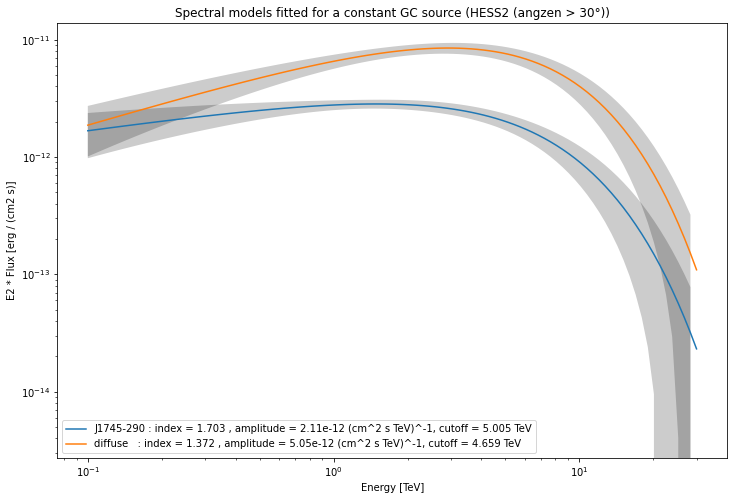

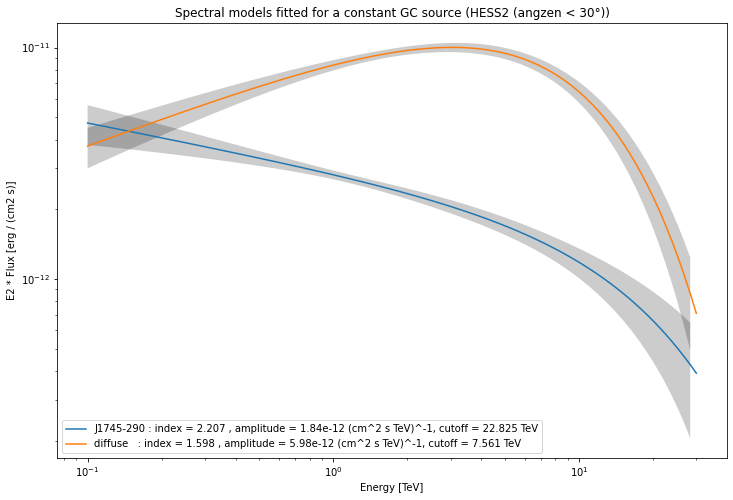

In [63]:
plot_spectrum(dataset2_zenhigh_tot.models, pathtry,"hess2_zenhigh_model_2cutoff_fr.pdf", "HESS2 (angzen > 30°)")
plot_spectrum(dataset2_zenlow_tot.models, pathtry,"hess2_zenlow_model_2cutoff_fr.pdf", "HESS2 (angzen < 30°)")

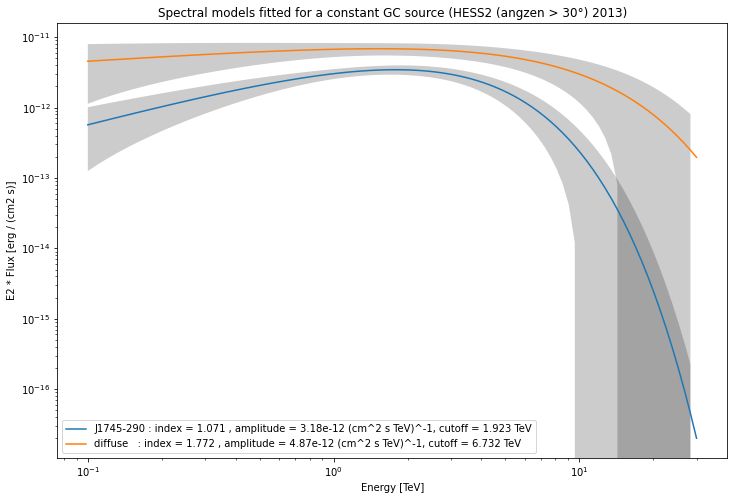

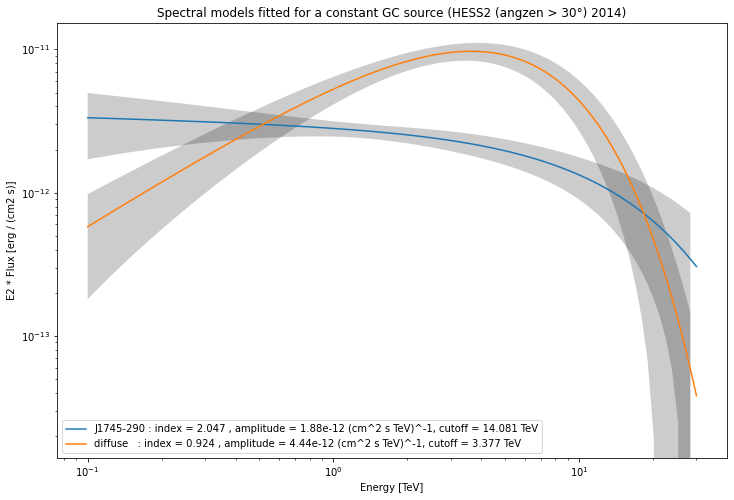

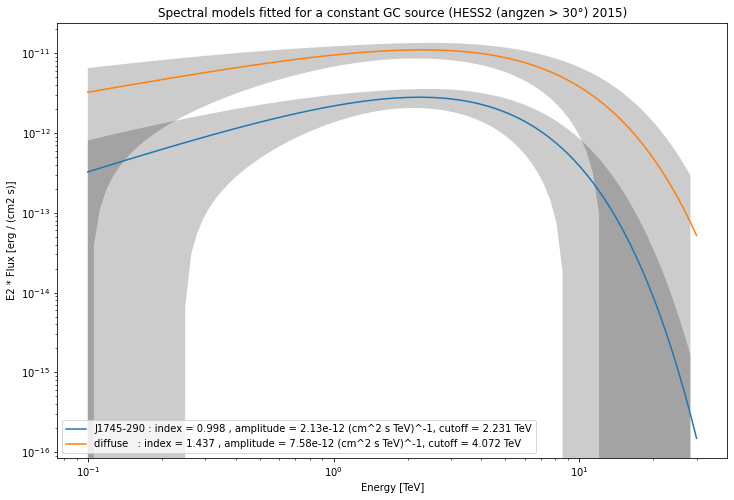

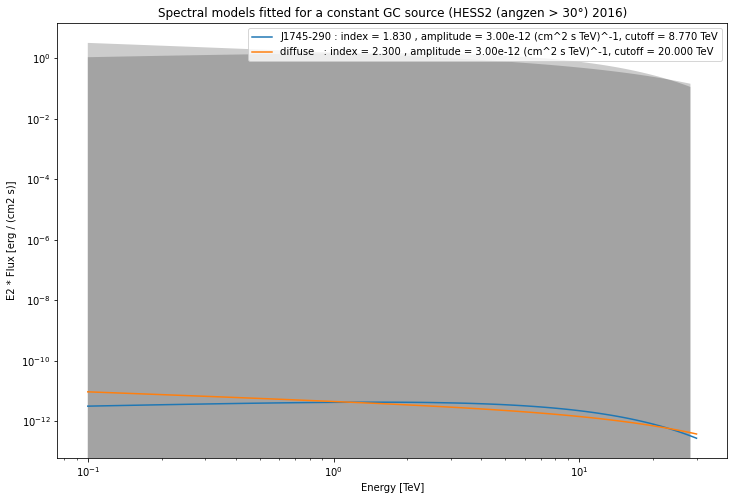

In [26]:
plot_spectrum(dataset2_zenhigh[2013].models, pathtry,"hess2_zenhigh_model2013_2cutoff_fr.pdf", "HESS2 (angzen > 30°) 2013")
plot_spectrum(dataset2_zenhigh[2014].models, pathtry,"hess2_zenhigh_model2014_2cutoff_fr.pdf", "HESS2 (angzen > 30°) 2014")
plot_spectrum(dataset2_zenhigh[2015].models, pathtry,"hess2_zenhigh_model2015_2cutoff_fr.pdf", "HESS2 (angzen > 30°) 2015")
plot_spectrum(dataset2_zenhigh[2016].models, pathtry,"hess2_zenhigh_model2016_2cutoff_fr.pdf", "HESS2 (angzen > 30°) 2016")

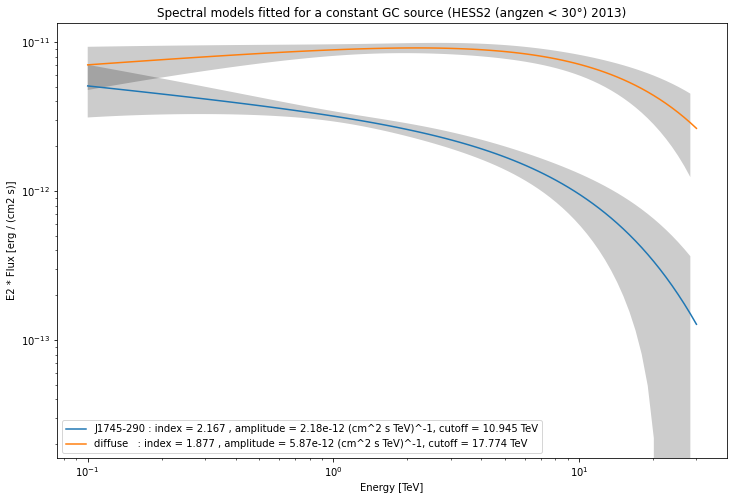

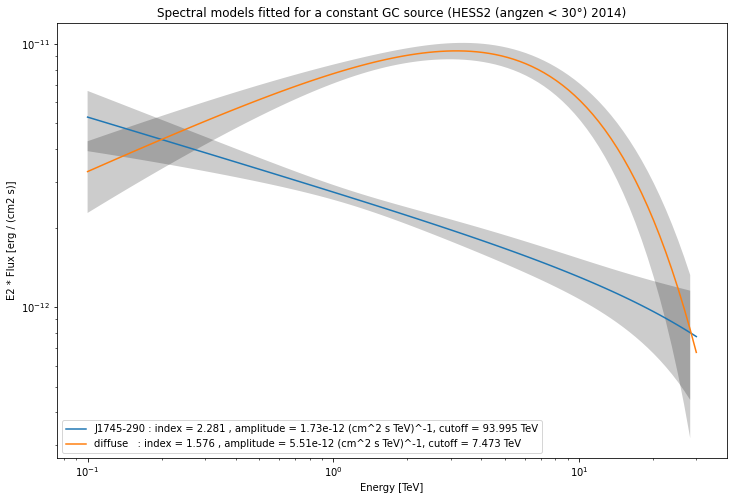

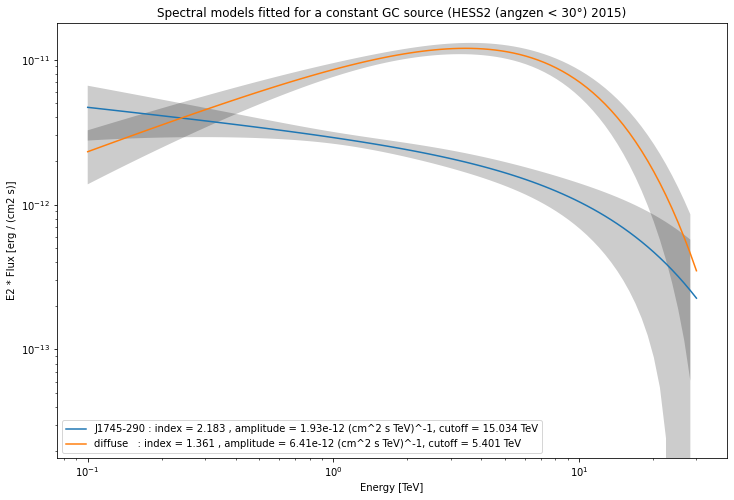

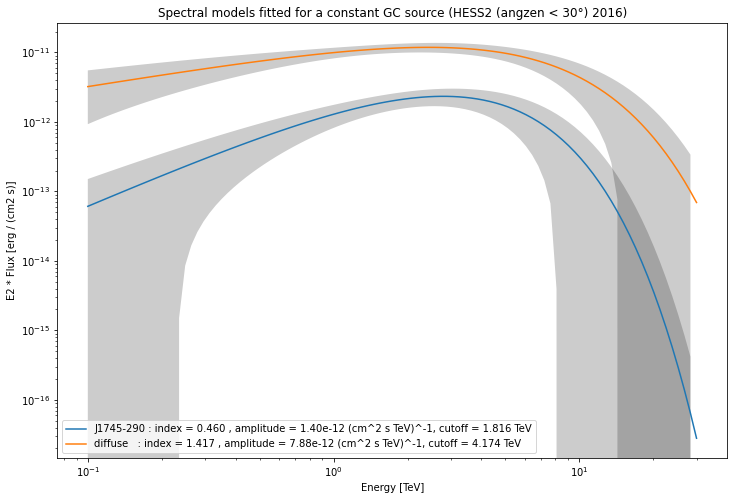

In [27]:
plot_spectrum(dataset2_zenlow[2013].models, pathtry,"hess2_zenlow_model2013_2cutoff_fr.pdf", "HESS2 (angzen < 30°) 2013")
plot_spectrum(dataset2_zenlow[2014].models, pathtry,"hess2_zenlow_model2014_2cutoff_fr.pdf", "HESS2 (angzen < 30°) 2014")
plot_spectrum(dataset2_zenlow[2015].models, pathtry,"hess2_zenlow_model2015_2cutoff_fr.pdf", "HESS2 (angzen < 30°) 2015")
plot_spectrum(dataset2_zenlow[2016].models, pathtry,"hess2_zenlow_model2016_2cutoff_fr.pdf", "HESS2 (angzen < 30°) 2016")

## Flux points

In [58]:
e_min, e_max = 0.5, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

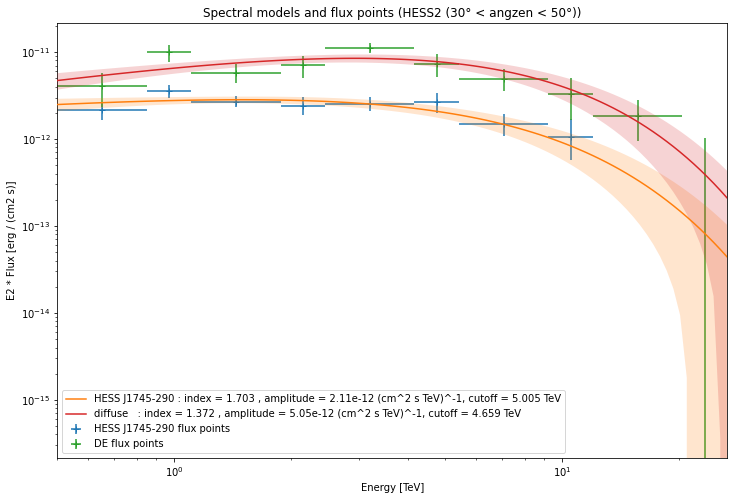

In [70]:
DoubleFluxPointsFitting(dataset2_zenhigh_tot, e_edges, "hess2_angzenhigh_2cutoff_fr", "HESS2 (30° < angzen < 50°)")

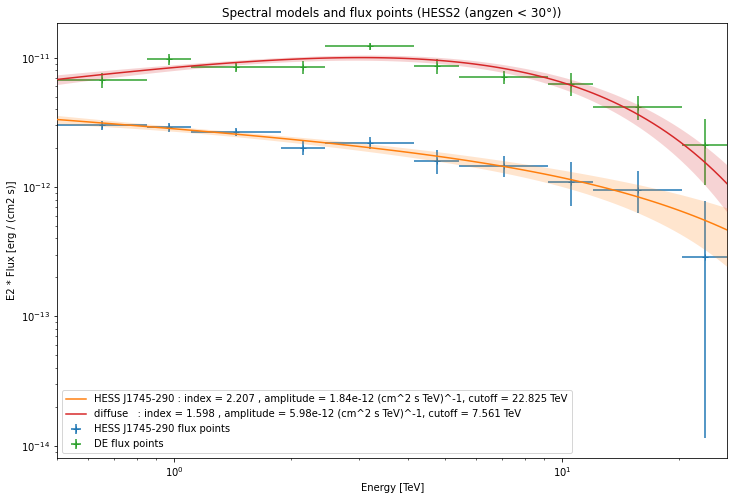

In [71]:
DoubleFluxPointsFitting(dataset2_zenlow_tot, e_edges, "hess2_angzenlow_2cutoff_fr", "HESS2 (angzen < 30°)")

In [ ]:
DoubleFluxPointsFitting(dataset2_zenhigh[2013], e_edges,"hess2_zenhigh_2013_2cutoff_fr.pdf", "HESS2 (angzen > 30°) 2013")
DoubleFluxPointsFitting(dataset2_zenhigh[2014], e_edges,"hess2_zenhigh_2014_2cutoff_fr.pdf", "HESS2 (angzen > 30°) 2014")
DoubleFluxPointsFitting(dataset2_zenhigh[2015], e_edges,"hess2_zenhigh_2015_2cutoff_fr.pdf", "HESS2 (angzen > 30°) 2015")
DoubleFluxPointsFitting(dataset2_zenhigh[2016], e_edges,"hess2_zenhigh_2016_2cutoff_fr.pdf", "HESS2 (angzen > 30°) 2016")

In [ ]:
DoubleFluxPointsFitting(dataset2_zenlow[2013], e_edges,"hess2_zenlow_2013_2cutoff_fr.pdf", "HESS2 (angzen < 30°) 2013")
DoubleFluxPointsFitting(dataset2_zenlow[2014], e_edges,"hess2_zenlow_2014_2cutoff_fr.pdf", "HESS2 (angzen < 30°) 2014")
DoubleFluxPointsFitting(dataset2_zenlow[2015], e_edges,"hess2_zenlow_2015_2cutoff_fr.pdf", "HESS2 (angzen < 30°) 2015")
DoubleFluxPointsFitting(dataset2_zenlow[2016], e_edges,"hess2_zenlow_2016_2cutoff_fr.pdf", "HESS2 (angzen < 30°) 2016")

## Maps

In [ ]:
mapdataset_tot.models = models_joint

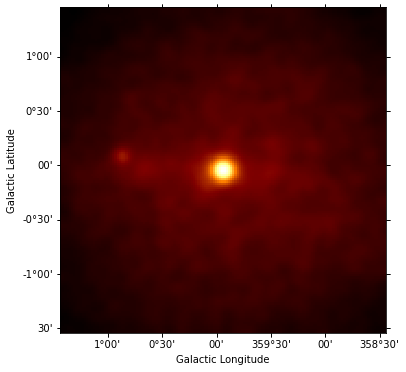

In [32]:
plt.figure(figsize=(6,6))
dataset2_zenlow_tot.counts.sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
#plt.plot((0,0), '*', color='black')
plt.savefig(pathtry/"counts_hess2-zenlow_map.pdf")

## Residuals

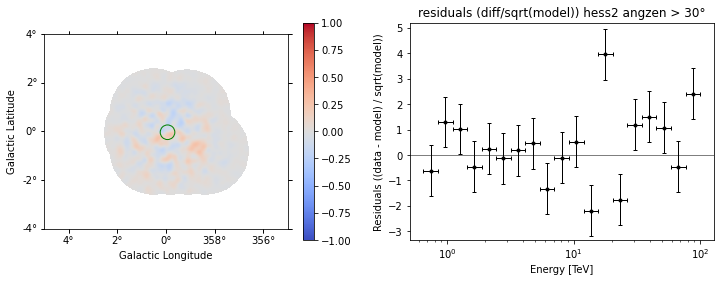

In [52]:
residuals(dataset2_zenhigh_tot,"hess2_zenhigh", "hess2 angzen > 30°")

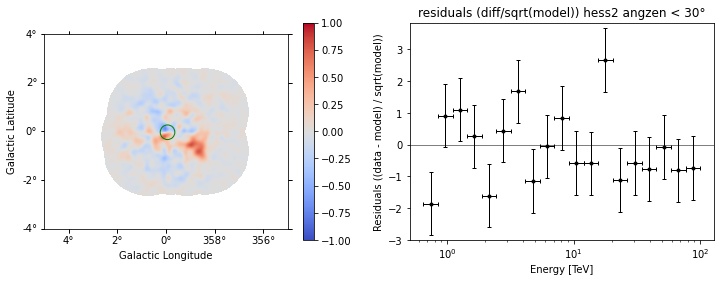

In [53]:
residuals(dataset2_zenlow_tot,"hess2_zenlow", "hess2 angzen < 30°")

## Significance map

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


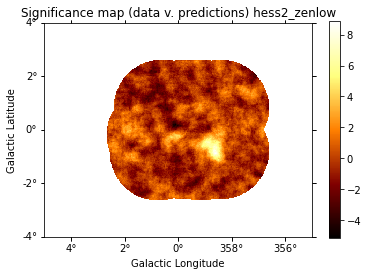

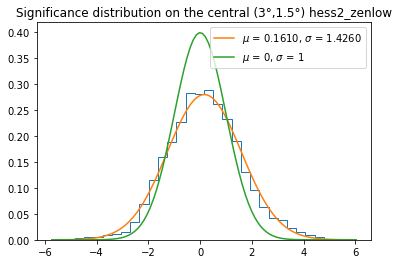

In [36]:
significance(dataset2_zenlow_tot,"hess2_zenlow", "hess2_zenlow")

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


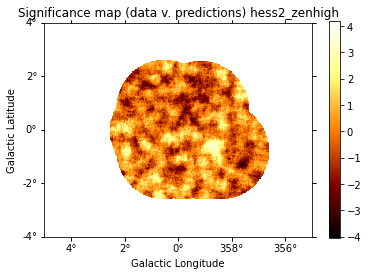

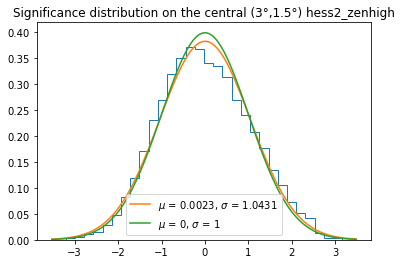

In [37]:
significance(dataset2_zenhigh_tot,"hess2_zenhigh", "hess2_zenhigh")

## Properly estimating the error on the parameter (using likelihood)

In [ ]:
with open(pathtry/'errors.txt', "a") as out:
    out.write("")
    
dataset = joint_dataset
models = models_joint
table = table_joint

In [ ]:
%%time

param = models[0].spectral_model.parameters["index"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)
    
    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "GC index = {0:03.3f}, errp = {1:03.3f}, errn = {2:03.3f}, err_naive = {3:03.3f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][2]
            )  + "\n"
        )

In [ ]:
%%time

param = models[2].spectral_model.parameters["index"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "DE index = {0:03.3f}, errp = {1:03.3f}, errn = {2:03.3f}, err_naive = {3:03.3f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][13]
            )  + "\n"
        )

In [ ]:
%%time

param = models[0].spectral_model.parameters["lambda_"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "GC lambda = {0:03.4f}, errp = {1:03.4f}, errn = {2:03.4f}, err_naive = {3:03.4f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][5]
            )  + "\n"
        )

In [ ]:
%%time

param = models[2].spectral_model.parameters["lambda_"]

if param.frozen == False:
    
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "DE lambda = {0:03.4f}, errp = {1:03.4f}, errn = {2:03.4f}, err_naive = {3:03.4f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][16]
            )  + "\n"
        )

In [ ]:
param = models[0].spectral_model.parameters["amplitude"]

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "GC ampli = {0:03.4e}, err_naive = {1:03.4e}".format(
            param.value, table['error'][3]
        )  + "\n"
    )


param = models[2].spectral_model.parameters["amplitude"]

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "DE ampli = {0:03.4e}, err_naive = {1:03.4e}".format(
            param.value, table['error'][14]
        )  + "\n"
    )

# Confidence contours

What will be interesting is how spectral indices and energy cutoffs are correlated, but we might want to see how parameters from different models are correlated too